In [49]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [50]:
env = BlackjackEnv()

In [51]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        dim = Q[observation].shape
        greedy_action = np.argmax(Q[observation])
        probs = np.full(dim, epsilon / dim[0])
        probs[greedy_action] += 1 - epsilon 
        return probs

    return policy_fn

In [58]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # A nested dictionary that maps state -> (action -> number of times state-action pair was encountered).
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    iterations = 0
    while iterations < num_episodes:
        # policy improvement: this function creates a new policy with the updated Q values 
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        is_done = False
        episode = []
        visited_states = {}
        s = env.reset()
        while is_done == False:
            # choose an action based on the policy, epsilon/ |A(s)| chance of random action
            action = np.random.choice(range(env.action_space.n), p=policy(s))
            new_s, r, is_done, _ = env.step(action)
            episode.append((s, action, r))
        for state,action,reward in episode: 
            # first-visit monte carlo update
            if state not in visited_states:
                N[state][action] += 1
                # incremental update of Q value is more memory efficient than simply keeping a record of all rewards
                # and averaging after every new reward
                Q[state][action] += discount_factor * ( 1./ N[state][action] ) * (reward - Q[state][action]) 
                visited_states.add(state)

        iterations += 1
    
    return Q, policy

In [55]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

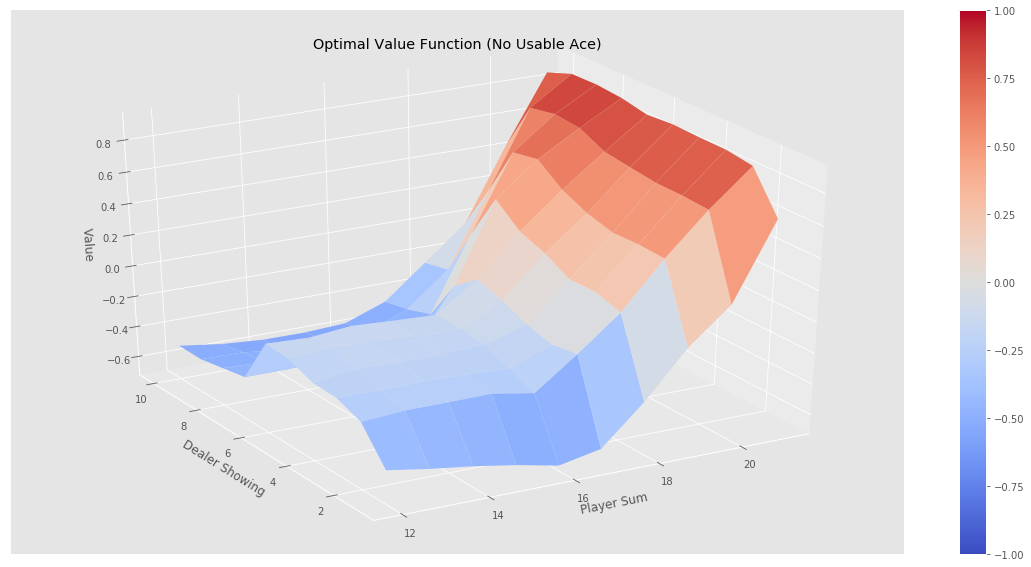

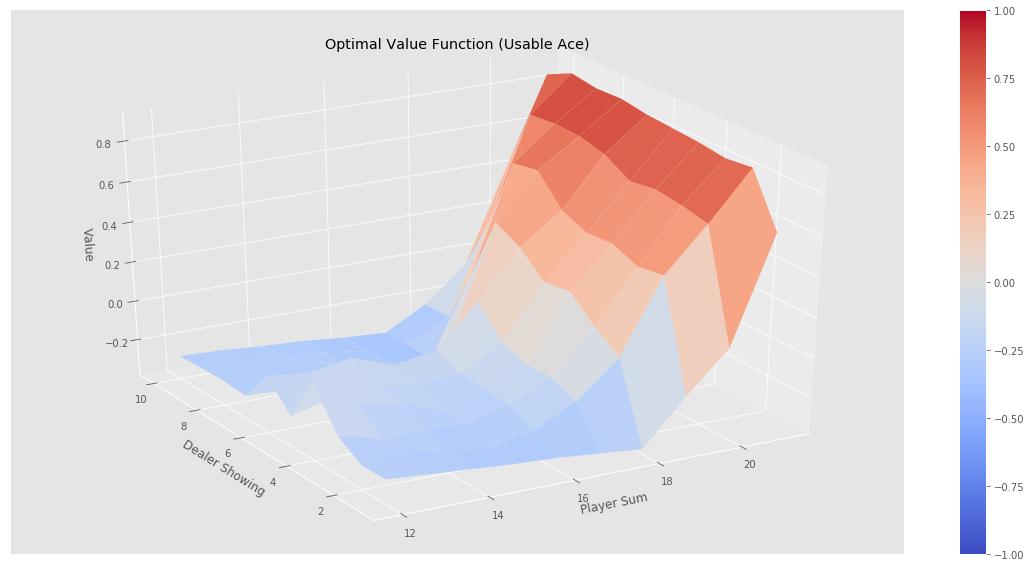

In [56]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

[((19, 10, False), array([-0.91397849, -1.        ]))]
